Import Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from scipy.stats import pearsonr
from sklearn.linear_model import LogisticRegression

Data Importing and Cleaning

In [2]:
df_timestamp = pd.read_csv('/Users/asifbala/Springboard-Data-Science/data_science_take_home_challenge_relax_inc/takehome_user_engagement.csv',encoding='latin-1')
df_users = pd.read_csv('/Users/asifbala/Springboard-Data-Science/data_science_take_home_challenge_relax_inc/takehome_users.csv', encoding='latin-1')

Create Binary Target Variable 'Adopted' to check for user adoption

In [3]:
date_list = list(df_timestamp['time_stamp'])

date = pd.to_datetime(date_list)

df_timestamp['time_stamp'] = list(date)

df_timestamp['time_stamp'] = df_timestamp['time_stamp'].dt.floor('d').astype(np.int64)

df_timestamp = df_timestamp.sort_values(['user_id', 'time_stamp']).drop_duplicates()

rolling_timestamp = df_timestamp.groupby('user_id')['time_stamp'].rolling(window=3)

days_rolling_timestamp = pd.to_timedelta((rolling_timestamp.max()- rolling_timestamp.min())).dt.days

print(days_rolling_timestamp.head())

adopted_users = days_rolling_timestamp[days_rolling_timestamp < 8].index.get_level_values('user_id').tolist()

adopted_users_set = set(adopted_users)

adopted_users_list = list(adopted_users_set)

new_df = pd.DataFrame({'range': range(len(adopted_users_list))}, index = adopted_users_list)

print(new_df.index)

df_users['adopted'] = np.where(df_users['object_id'].isin(new_df.index),1,0)

print(df_users['adopted'].head())

print(df_users.head())

user_id   
1        0     NaN
2        1     NaN
         2     NaN
         3    24.0
         4    26.0
Name: time_stamp, dtype: float64
Int64Index([8192,    2, 8196, 8201,   10,   20, 8214, 8217, 8220, 8221,
            ...
            8130, 8134, 8137, 8149, 8156, 8159, 8161, 8166, 8169, 8191],
           dtype='int64', length=1656)
0    0
1    1
2    0
3    0
4    0
Name: adopted, dtype: int64
   object_id        creation_time               name  \
0          1  2014-04-22 03:53:30     Clausen August   
1          2  2013-11-15 03:45:04      Poole Matthew   
2          3  2013-03-19 23:14:52  Bottrill Mitchell   
3          4  2013-05-21 08:09:28    Clausen Nicklas   
4          5  2013-01-17 10:14:20          Raw Grace   

                        email creation_source  last_session_creation_time  \
0    AugustCClausen@yahoo.com    GUEST_INVITE                1.398139e+09   
1      MatthewPoole@gustr.com      ORG_INVITE                1.396238e+09   
2  MitchellBottrill@gustr.com 

Check for Class Imbalance

In [4]:
class_counts = df_users['adopted'].value_counts()

print(class_counts)

0    10344
1     1656
Name: adopted, dtype: int64


Fix Class Imbalance

1    1656
0    1656
Name: adopted, dtype: int64


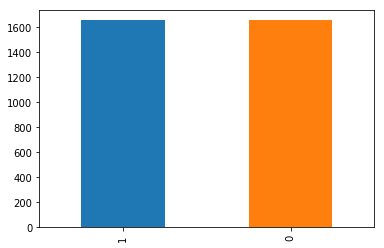

    object_id        creation_time            name  \
1           2  2013-11-15 03:45:04   Poole Matthew   
9          10  2013-01-16 22:08:03    Santos Carla   
19         20  2014-03-06 11:46:38   Helms Mikayla   
32         33  2014-03-11 06:29:09     Araujo José   
41         42  2012-11-11 19:05:07  Pinto Giovanna   

                            email creation_source  last_session_creation_time  \
1          MatthewPoole@gustr.com      ORG_INVITE                1.396238e+09   
9   CarlaFerreiraSantos@gustr.com      ORG_INVITE                1.401833e+09   
19             lqyvjilf@uhzdq.com          SIGNUP                1.401364e+09   
32     JoseMartinsAraujo@cuvox.de    GUEST_INVITE                1.401518e+09   
41    GiovannaCunhaPinto@cuvox.de          SIGNUP                1.401045e+09   

    opted_in_to_mailing_list  enabled_for_marketing_drip  org_id  \
1                          0                           0       1   
9                          1                        

In [5]:
#Find Number of samples which are adopted
no_adopted = len(df_users[df_users['adopted'] == 1])

#Get indices of non adopted samples
non_adopted_indices = df_users[df_users.adopted == 0].index

#Random sample non adopted indices
random_indices = np.random.choice(non_adopted_indices,no_adopted, replace=False)

#Find the indices of adopted samples
adopted_indices = df_users[df_users.adopted == 1].index

#Concat adopted indices with sample non-adopted ones
under_sample_indices = np.concatenate([adopted_indices,random_indices])

#Get Balanced Dataframe
under_sample = df_users.loc[under_sample_indices]

class_counts = under_sample['adopted'].value_counts()

print(class_counts)

class_counts.plot(kind='bar')

plt.show()

print(under_sample.head())

# VISUAL EDA

adopted               0    1
creation_source             
GUEST_INVITE        273  369
ORG_INVITE          604  574
PERSONAL_PROJECTS   335  172
SIGNUP              274  302
SIGNUP_GOOGLE_AUTH  170  239


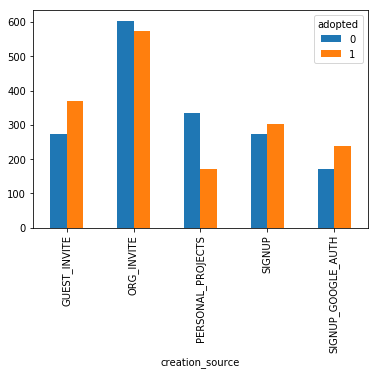

In [6]:
creation_source_adopted = pd.crosstab(under_sample['creation_source'],under_sample['adopted'])

print(creation_source_adopted)

creation_source_adopted.plot(kind='bar')

plt.show()

In [7]:
org_id_adopted = pd.crosstab(under_sample['org_id'],under_sample['adopted'])

print(type(org_id_adopted))

print(org_id_adopted.head(30))

#There isnt any significant difference between adopted and not adopted for the many organizations. 

<class 'pandas.core.frame.DataFrame'>
adopted   0   1
org_id         
0        45  12
1        36  16
2        30  15
3        27  14
4        20  17
5        15  12
6        32  11
7        16  16
8        11  10
9        20  14
10       22  10
11        8   8
12       12   6
13        8  14
14       12   5
15       10   8
16        8   8
17       10   5
18        9   7
19        9   7
20       12  10
21        6   4
22       11   4
23       10   5
24        9  10
25       10   8
26        4   2
27        7   6
28       12   5
29        9   3


adopted                      0     1
opted_in_to_mailing_list            
0                         1240  1227
1                          416   429


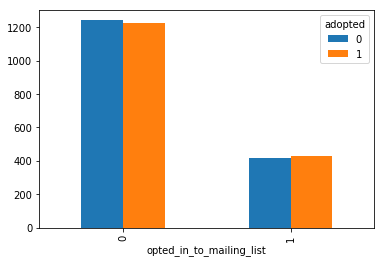

In [8]:
opted_mailing_list_adopted = pd.crosstab(under_sample['opted_in_to_mailing_list'],under_sample['adopted'])

print(opted_mailing_list_adopted)

opted_mailing_list_adopted.plot(kind='bar')

plt.show()

adopted                        0     1
enabled_for_marketing_drip            
0                           1429  1399
1                            227   257


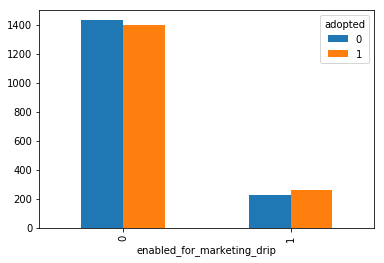

In [9]:
enabled_marketing_drip_adopted = pd.crosstab(under_sample['enabled_for_marketing_drip'],under_sample['adopted'])

print(enabled_marketing_drip_adopted)

enabled_marketing_drip_adopted.plot(kind='bar')

plt.show()

In [10]:
invited_by_user_id_adopted = pd.crosstab(under_sample['invited_by_user_id'],under_sample['adopted'])

print(invited_by_user_id_adopted.head(10))

adopted             0  1
invited_by_user_id      
23.0                1  0
29.0                0  1
37.0                1  0
47.0                4  0
49.0                0  1
50.0                0  2
69.0                1  0
78.0                1  0
79.0                0  1
93.0                1  0


Determined the effect of the the month of the user creation on being adopted/not adopted. Resampled creation time to monthly and determined the number of adopted/not adopted for each month.

creation_time
2012-05-31     2
2012-06-30    73
2012-07-31    60
2012-08-31    68
2012-09-30    68
Freq: M, Name: adopted, dtype: int64
creation_time
2012-05-31     2
2012-06-30    62
2012-07-31    48
2012-08-31    42
2012-09-30    58
Freq: M, Name: not_adopted, dtype: int64
               adopted  not_adopted
creation_time                      
2012-05-31           2            2
2012-06-30          73           62
2012-07-31          60           48
2012-08-31          68           42
2012-09-30          68           58
2012-10-31          69           60
2012-11-30          65           57
2012-12-31          63           45
2013-01-31          58           54
2013-02-28          72           50
2013-03-31          69           65
2013-04-30          70           58
2013-05-31          60           54
2013-06-30          80           57
2013-07-31          63           66
2013-08-31          77           65
2013-09-30          74           70
2013-10-31          93           67
2013

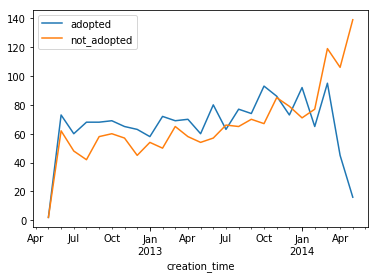

In [11]:
under_sample['creation_time'] = pd.to_datetime(under_sample['creation_time'])

under_sample2 = under_sample.set_index('creation_time')

under_sample_monthly_sum = under_sample2.resample('M').sum()

adopted_monthly = under_sample_monthly_sum['adopted']

print(adopted_monthly.head(5))

under_sample_monthly_count = under_sample2.resample('M').count()

total_monthly = under_sample_monthly_count['adopted']

not_adopted_monthly = total_monthly - adopted_monthly

not_adopted_monthly.name = 'not_adopted'

print(not_adopted_monthly.head(5))

monthly_dataset = pd.concat([adopted_monthly,not_adopted_monthly],axis=1)

print(monthly_dataset)

monthly_dataset.plot()

plt.show()

I would use the following features after preprocessing, creating the target variable, and EDA. These features have demonstrated a strong difference in results between adoped and non adopted users.

Feature One:
Whether user is in group Guest_invite or not.

Feature Two:
Whether user is in group personal projects or not.

Feature Three:
Whether user is in group SignUp_Google_auth or not.

There were no other features that held a significant difference between adopted and not adopted users.